# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


---

## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
# !pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
# apt-get install -y fonts-nanum

In [2]:
%pip install -q scikit-lego

Note: you may need to restart the kernel to use updated packages.


In [3]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'../NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import random
from sklearn.base import clone

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

# cv
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# model
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor
from sklego.linear_model import LADRegression
from sklearn.ensemble import VotingRegressor, StackingRegressor

import sklearn
import eli5
from eli5.sklearn import PermutationImportance

---

## 2. Data Load

### ⚙️Setting & Helper func.

In [4]:
class CONFIG:
    '''
    > General Options
    '''
    # global seed
    seed = 42
    # max rows to display for pandas dataframes
    display_max_rows = 100
    # name of the response variate we are trying to predict
    response_variate = 'target'
    
    '''
    > Preprocessing Options
    '''
    # number of folds to split the data for CV
    num_folds = 10
    # KFold: 일반적인 때
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    # StratifiedKFold: 클래스가 불균형할 때
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    # RepeatedKFold: 데이터가 작을 때 (안정적인 성능 추정)
    rkf = RepeatedKFold(n_splits=num_folds, n_repeats=3, random_state=seed)
    
    '''
    > Modelling Options
    '''
    # whether to use optuna tuning or not
    # if False, then we load in pretuned weights for the LGBM models
    use_optuna_tuning = False
    # if use_optuna_tuning=True
    num_trials_optuna = 80
    # number of trials to use for early stopping
    num_trials_early_stopping = 40
    
    '''
    > Post-Modelling Options
    '''
    # number of most important features to display
    # for the feature importances plot
    num_features_to_display = 50

In [ ]:
def generateXY(trainData):
    X = trainData.drop(CONFIG.response_variate, axis=1)
    Y = trainData[CONFIG.response_variate]
    return X,Y

In [5]:
tqdm.pandas()

# sns.set_style("whitegrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', CONFIG.display_max_rows)
warnings.simplefilter('ignore')

random.seed(CONFIG.seed)

#### 2.1. 데이터 로드

In [6]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../data/train.csv'
test_path  = '../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [7]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,언주로 3,NaN,,직거래,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


---

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, **용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행**하도록 하겠습니다.

In [8]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [9]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [10]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 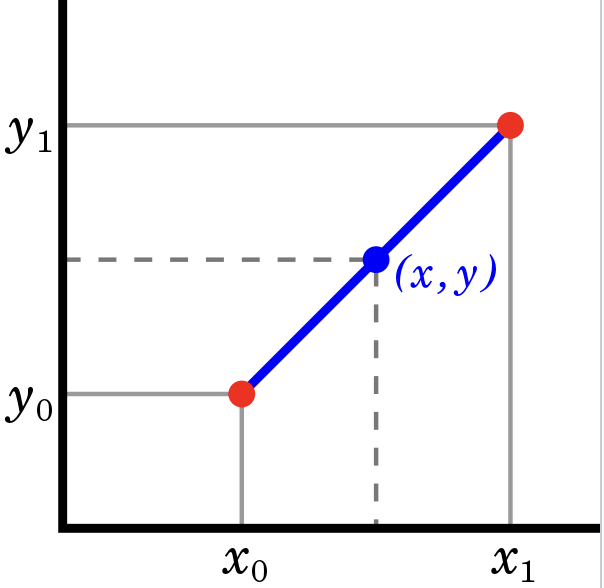

In [11]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [12]:
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [13]:
display(concat['중개사소재지'].value_counts())

-                    1090013
서울 노원구                  2627
서울 송파구                  2540
서울 강남구                  2508
서울 강동구                  2038
                      ...   
서울 강북구, 서울 양천구             1
경기 남양주시, 경기 성남수정구          1
서울 송파구, 인천 계양구             1
경기 연천군, 서울 송파구             1
서울 중랑구, 인천 부평구             1
Name: 중개사소재지, Length: 739, dtype: int64

In [14]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

✅ 추가 결측치 처리

In [15]:
# 증여 또는 직거래로, 해당 거래는 나머지와 타겟에서 다른 양상을 보임
concat['해제사유발생여부'] = pd.notnull(concat['해제사유발생일']).astype(int)
concat['등기신청여부'] = pd.notnull(concat['등기신청일자']).astype(int)

<Axes: xlabel='해제사유발생여부', ylabel='target'>

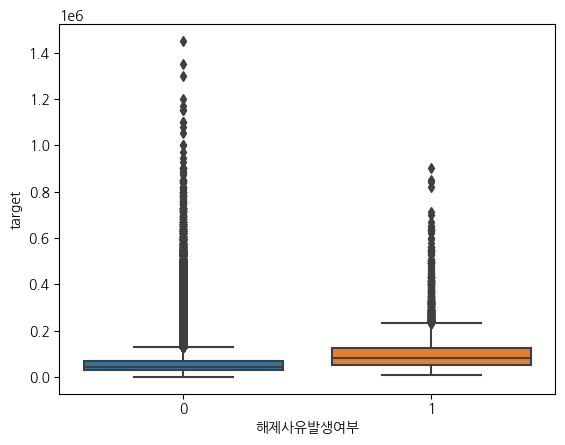

In [18]:
sns.boxplot(x='해제사유발생여부', y='target', data=concat)

<Axes: xlabel='등기신청여부', ylabel='target'>

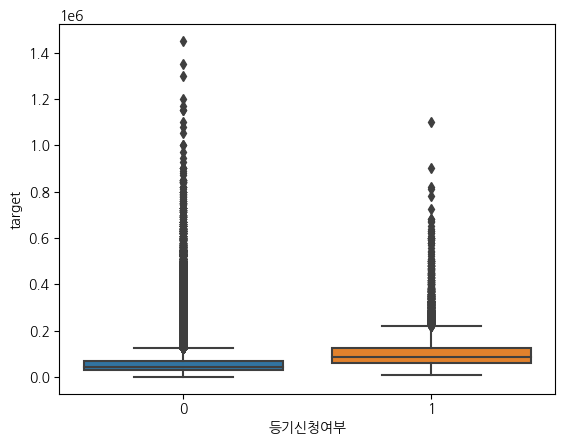

In [19]:
sns.boxplot(x='등기신청여부', y='target', data=concat)

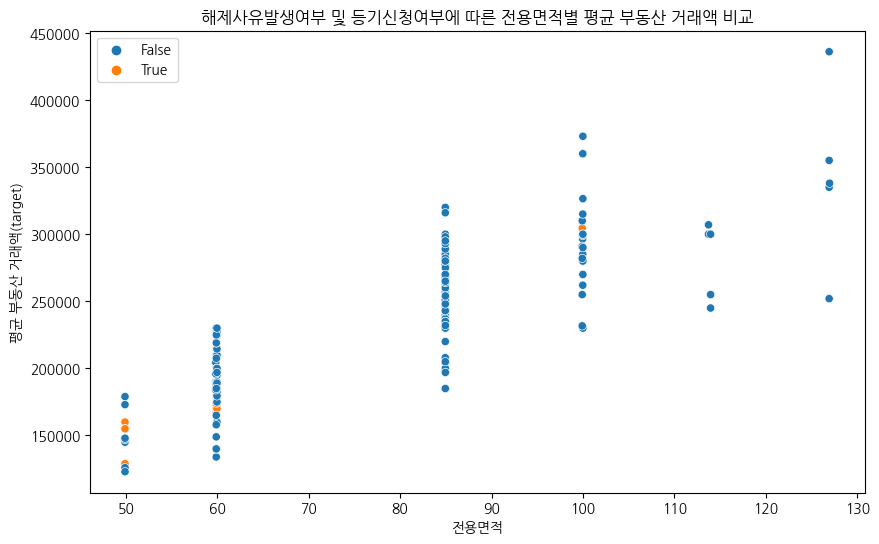

In [20]:
"""
✅추가 EDA
"""

df2 = concat[concat['아파트명']=='래미안블레스티지']

# 전용면적별로 target 평균 계산
df_grouped = df2.groupby('전용면적').agg({'target':'mean'}).reset_index()

# 조건에 따른 target 값 비교를 위한 그래프
plt.figure(figsize=(10, 6))

# 해제사유발생여부 또는 등기신청여부가 1인 경우와 그렇지 않은 경우로 target 비교
condition = (df2['해제사유발생여부'] == 1) | (df2['등기신청여부'] == 1)

# Seaborn의 scatterplot을 사용하여 시각화
sns.scatterplot(x='전용면적', y='target', hue=condition, data=df2)

plt.title('해제사유발생여부 및 등기신청여부에 따른 전용면적별 평균 부동산 거래액 비교')
plt.xlabel('전용면적')
plt.ylabel('평균 부동산 거래액(target)')
plt.show()

In [21]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

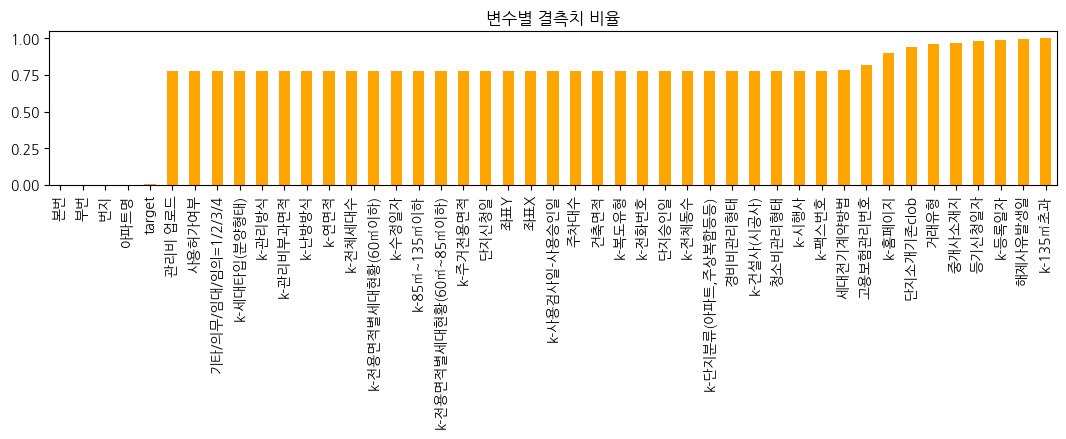

In [22]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [23]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '해제사유발생여부', '등기신청여부']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [24]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [25]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
고용보험관리번호  

In [28]:
# # ✅ 추가 결측치 처리2

# # 결측치가 없는 데이터로부터 새로운 데이터프레임을 만듭니다.
# non_missing_df = concat_select.dropna(subset=['좌표X', '좌표Y', '아파트명'])
# non_missing_df = non_missing_df[['좌표X', '좌표Y', '아파트명']].drop_duplicates()

# # 원본 데이터프레임과 새로운 데이터프레임을 병합합니다.
# merged_df = pd.merge(concat_select, non_missing_df, on=['좌표X', '좌표Y'], how='left', suffixes=('', '_new'))

# # 병합된 결과에서 '아파트명'의 결측치를 새로운 데이터프레임의 '아파트명'으로 채웁니다.
# merged_df['아파트명'] = merged_df['아파트명'].fillna(merged_df['아파트명_new'])

# # 불필요한 칼럼을 제거합니다.
# merged_df.drop(columns=['아파트명_new'], inplace=True)

# # 결과 출력
# merged_df

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,해제사유발생여부,등기신청여부
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,0,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0,0,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0,0,0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0,0,0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128177,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307,19,13,2014,신내역로1길 85,아파트,024969683,024969685,기타,위탁관리,혼합식,개별난방,16.0,1402.0,한신공영(주),SH공사,2014-06-18 00:00:00.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,2023-09-23 09:00:52.0,2048279333,위탁,종합계약,위탁,14171.0,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1,1,0
1128178,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307,25,12,2014,신내역로1길 85,아파트,024969683,024969685,기타,위탁관리,혼합식,개별난방,16.0,1402.0,한신공영(주),SH공사,2014-06-18 00:00:00.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,2023-09-23 09:00:52.0,2048279333,위탁,종합계약,위탁,14171.0,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1,0,0
1128179,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308,27,12,2014,신내역로1길 85,아파트,024969683,024969685,기타,위탁관리,혼합식,개별난방,16.0,1402.0,한신공영(주),SH공사,2014-06-18 00:00:00.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,2023-09-23 09:00:52.0,2048279333,위탁,종합계약,위탁,14171.0,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1,0,0
1128180,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309,2,18,2014,신내역로1길 85,아파트,024969683,024969685,기타,위탁관리,혼합식,개별난방,16.0,1402.0,한신공영(주),SH공사,2014-06-18 00:00:00.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,2023-09-23 09:00:52.0,2048279333,위탁,종합계약,위탁,14171.0,1568.0,의무,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1,0,0


In [29]:
# # ✅ 추가 결측치 처리2

# # 'k-'로 시작하는 피쳐들을 찾아냅니다.
# k_features = [col for col in concat_select.columns if col.startswith('k-')]

# # 데이터 카피
# df3 = concat_select.copy()

# # 결측치가 있는 원본 데이터를 따로 저장
# missing_data = df3[k_features].isnull()

# # 아파트명으로 그룹화하고 결측치를 보간합니다.
# for feature in k_features:
#     # 각 그룹 내에서 인덱스를 재설정
#     df3[feature] = df3.groupby('아파트명')[feature].apply(lambda x: x.reset_index(drop=True).fillna(method='ffill').fillna(method='bfill'))


# print("보간된 데이터:")
# display(df3)

# print("원본 데이터의 결측치 위치:")
# display(missing_data)

In [ ]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 "unknown"이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 47 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전화번호                  251244 non-null   object 
 13  k-팩스번호                  248746 non-null   object 
 14  k-세대타

In [ ]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [ ]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '해제사유발생여부', '등기신청여부']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [ ]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [ ]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

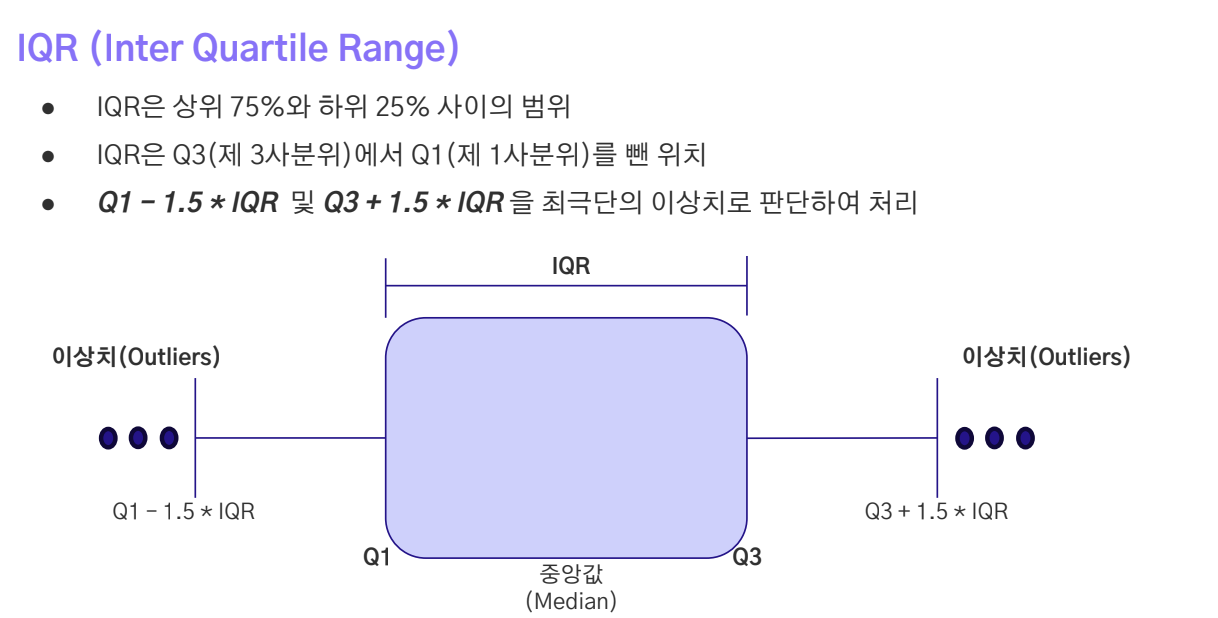

In [ ]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 47)


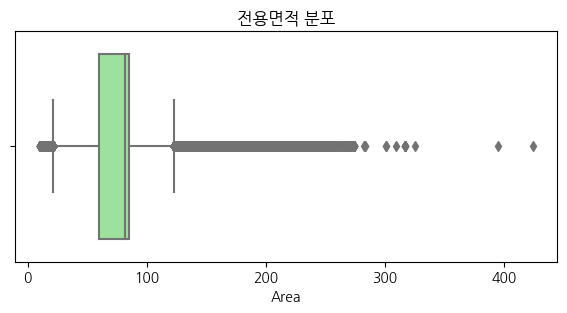

In [ ]:
# 대표적인 연속형 변수인 "전용 면적" 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [ ]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [ ]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [ ]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038846, 47)


In [ ]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1029574
1       9272
Name: is_test, dtype: int64

---

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [ ]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

# 년월 구분 및 2020년 이후 데이터만 추출
concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4]).astype(int)
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:]).astype(int)
concat_select = concat_select[concat_select['계약년'].astype('int') >= 2020]

del concat_select['계약년월']
print(concat_select.shape)

(149882, 49)


In [ ]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '해제사유발생여부', '등기신청여부', '구', '동', '계약년', '계약월'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [ ]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [ ]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [ ]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '해제사유발생여부', '등기신청여부', '구', '동', '계약년', '계약월', '강남여부'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [ ]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    149882.000000
mean       2001.155295
std          10.180857
min        1961.000000
10%        1988.000000
25%        1994.000000
50%        2001.000000
75%        2008.000000
80%        2010.000000
90%        2016.000000
max        2023.000000
Name: 건축년도, dtype: float64

In [ ]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [ ]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,해제사유발생여부,등기신청여부,구,동,계약년,계약월,강남여부,신축여부
201009,651-1,651.0,1.0,개포더샵트리에,105.8064,29,8,2021,개포로 311,아파트,025763999,25763998.0,분양,위탁관리,계단식,지역난방,2.0,232.0,포스코,개포우성9차모델링조합,2021-12-01 00:00:00.0,44951.0,24878.0,31174.0,0.0,0.0,232.0,2023-09-23 17:23:08.0,NULL,위탁,종합계약,위탁,2724.46,305.0,의무,2022-02-23 13:01:10.0,Y,N,127.056394,37.484892,2022-02-23 11:05:05.0,240000.0,0,0,1,강남구,개포동,2023,6,1,1


In [ ]:
concat_select.shape

(149882, 51)

In [ ]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '해제사유발생여부', '등기신청여부', '구', '동', '계약년', '계약월', '강남여부',
       '신축여부'],
      dtype='object')

In [ ]:
concat_select.columns = ["".join(c for c in col if c not in set('{}:,'))
                         for col in concat_select.columns]

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

In [ ]:
##### 한은 기준금리 Feature 생성 #####

monthly_interest_rates_df = pd.read_csv('../data/monthly_interest_rates.csv')



# 기준금리 데이터프레임과 주택 거래 데이터프레임 병합
merged_df = pd.merge(concat_select, monthly_interest_rates_df, left_on=['계약년', '계약월'], right_on=['Year', 'Month'], how='left')
concat_select = merged_df.rename(columns={'Rate':'기준금리(%)'})

# 병합된 데이터프레임에서 필요없는 열(Year, Month) 제거
concat_select.drop(['Year', 'Month'], axis=1, inplace=True)

# 병합된 데이터프레임 확인
concat_select.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k-단지분류(아파트주상복합등등),k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,해제사유발생여부,등기신청여부,구,동,계약년,계약월,강남여부,신축여부,기준금리(%)
0,651-1,651.0,1.0,개포더샵트리에,105.8064,29,8,2021,개포로 311,아파트,025763999,25763998.0,분양,위탁관리,계단식,지역난방,2.0,232.0,포스코,개포우성9차모델링조합,2021-12-01 00:00:00.0,44951.0,24878.0,31174.0,0.0,0.0,232.0,2023-09-23 17:23:08.0,NULL,위탁,종합계약,위탁,2724.46,305.0,의무,2022-02-23 13:01:10.0,Y,N,127.056394,37.484892,2022-02-23 11:05:05.0,240000.0,0,0,1,강남구,개포동,2023,6,1,1,3.5


---

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [ ]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(140610, 51) (9272, 51)


In [ ]:
dt_test.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k-단지분류(아파트주상복합등등),k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,해제사유발생여부,등기신청여부,구,동,계약년,계약월,강남여부,신축여부,기준금리(%)
140610,658-1,658.0,1.0,개포6차우성,79.97,26,5,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,13250.0,0,0,강남구,개포동,2023,7,1,0,3.5


In [ ]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

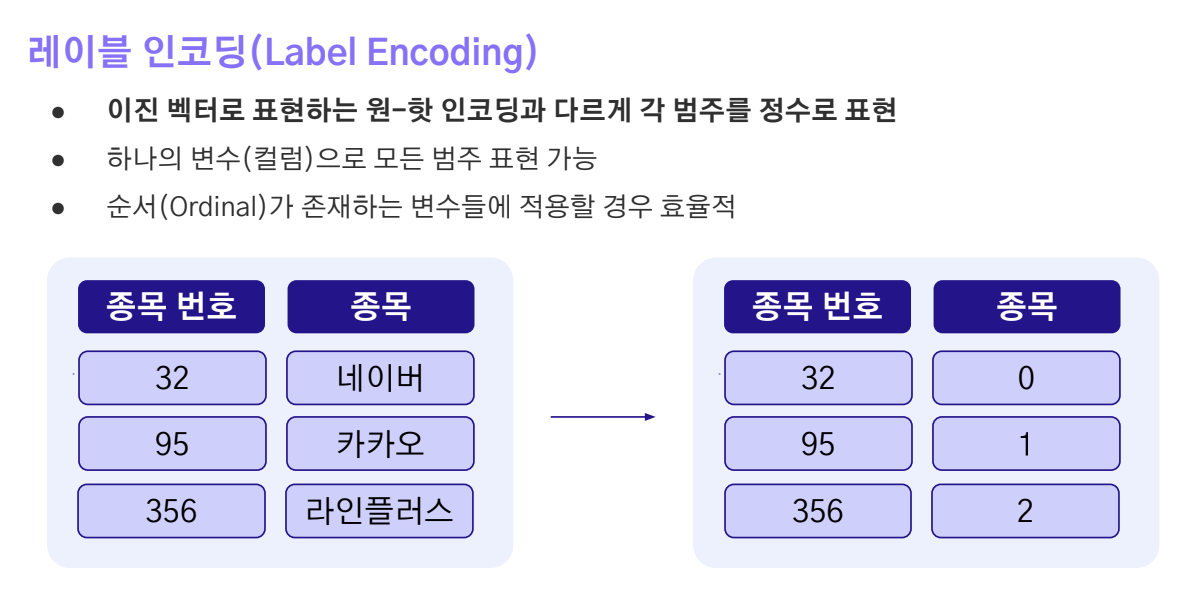

In [ ]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '해제사유발생여부', '등기신청여부', '계약년', '계약월', '강남여부', '신축여부', '기준금리(%)']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '구', '동']


In [ ]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

 78%|███████▊  | 21/27 [00:01<00:00, 20.96it/s]

100%|██████████| 27/27 [00:01<00:00, 14.68it/s]


In [ ]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k-단지분류(아파트주상복합등등),k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,해제사유발생여부,등기신청여부,구,동,계약년,계약월,강남여부,신축여부,기준금리(%)
0,3672,1090,1,260,105.8064,29,8,2021,355,3,438,980,2,1,1,4,2.0,232.0,282,80,636,44951.0,24878.0,31174.0,0.0,0.0,232.0,201,509,2,2,2,2724.46,305.0,2,695,1,0,127.056394,37.484892,234,240000.0,0,1,0,8,2023,6,1,1,3.5


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [ ]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

# Target과 독립변수들을 분리해줍니다.
X, y = generateXY(dt_train)

- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [ ]:
# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2023)

# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 10556.609786140521


In [ ]:
# 베이스라인
# RMSE test: 5851.882141463051

In [ ]:
# Create an empty array to store the out-of-fold predictions
oof_preds = np.zeros(y_train.shape[0])

# Create an empty list to store the cv scores
cv_scores = []

# Perform cross-validation
for train_index, valid_index in CONFIG.kf.split(X, y):
    model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)

    # Split the data
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    # Fit the model
    model.fit(X_train_fold, y_train_fold)

    # Compute predictions
    preds = model.predict(X_valid_fold)

    # Store predictions for this fold in oof_preds
    oof_preds[valid_index] = preds

    # Compute the cv score and append it to the list
    score = np.sqrt(metrics.mean_squared_error(y_valid_fold, preds))
    cv_scores.append(score)

# Store the average CV score and print
avg_cv_score = np.mean(cv_scores)

print(f'RMSE test: {avg_cv_score}')

RMSE test: 11027.425215915335


- 변수 중요도도 확인해보도록 하겠습니다.

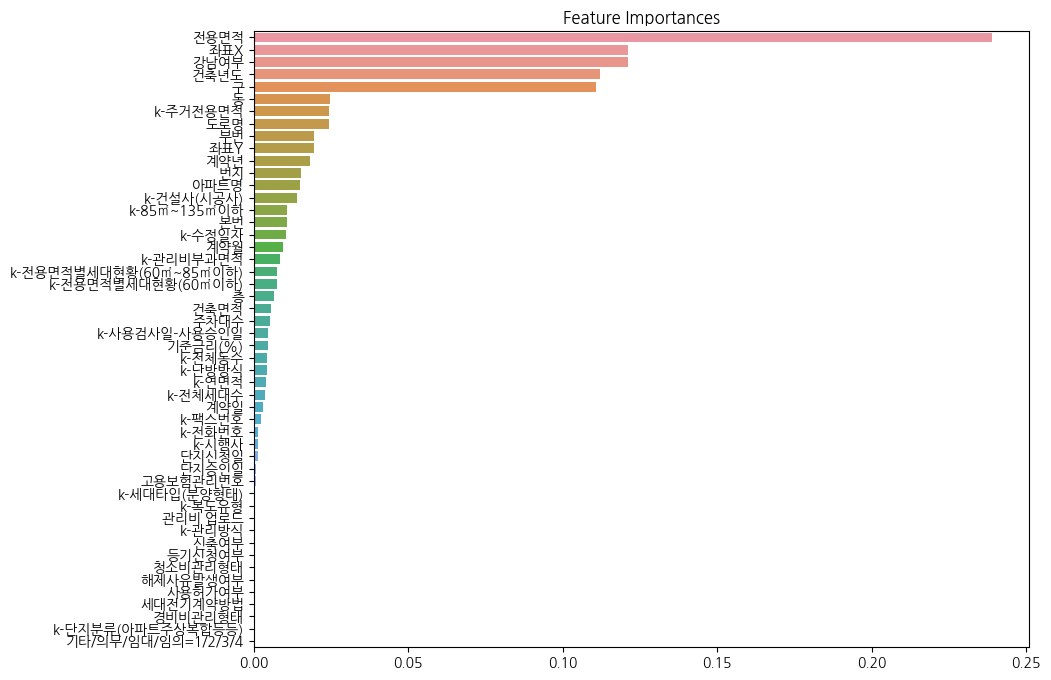

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [ ]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
1330203508.9021 ± 49532566.7984,전용면적
1228803197.3237 ± 23942176.7147,강남여부
1048194752.2555 ± 1557696.4944,구
686493490.6401 ± 22204170.8555,건축년도
628333236.8725 ± 32266584.4371,좌표X
177580005.7050 ± 15393473.2281,k-주거전용면적
148631471.7647 ± 6330345.1744,계약년
135286815.1894 ± 8046795.9363,부번
135261698.3942 ± 4382112.0338,도로명
132649370.6837 ± 6728582.9377,동


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [ ]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [ ]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [ ]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [ ]:
X_val_sort.head()

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k-단지분류(아파트주상복합등등),k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,해제사유발생여부,등기신청여부,구,동,계약년,계약월,강남여부,신축여부,기준금리(%),target,pred,error
25290,4186,1204,0,1853,107.4700,11,1,1973,4226,0,945,1212,0,0,0,0,5.053425,824.793836,72,58,649,100024.669178,65150.881507,65263.052740,186.615753,598.471918,38.908904,713,509,0,0,0,39.146301,713.239726,0,708,0,1,127.015916,37.600846,247,0,0,14,106,2022,1,1,0,1.25,287000.0,540400.0,6.421156e+10
126243,1128,471,230,1797,75.0900,22,7,1980,5120,0,945,1212,0,0,0,0,3.000000,497.690355,72,58,649,164140.406091,68682.431472,89228.710660,0.000000,25.583756,175.761421,713,509,0,0,0,1146.987817,186.802030,0,708,0,1,127.116734,37.512207,247,0,0,17,182,2020,8,1,0,0.50,219000.0,81460.0,1.891725e+10
126244,1128,471,230,1797,75.0900,25,1,1980,5120,0,945,1212,0,0,0,0,3.000000,498.020939,72,58,649,164278.519670,68737.622462,89300.878173,0.000000,25.614213,175.708756,713,509,0,0,0,1145.429410,186.548223,0,708,0,1,127.116703,37.512206,247,0,0,17,182,2020,9,1,0,0.50,216000.0,83260.0,1.761991e+10
74694,1922,676,237,3877,98.3600,28,13,1975,5579,0,945,1212,0,0,0,0,5.364948,301.628179,72,58,649,54117.383505,29757.466667,33618.368385,38.738144,130.584192,111.021306,713,509,0,0,0,3604.906694,455.773196,0,708,0,1,127.004686,37.529996,247,0,0,20,240,2021,5,0,0,0.50,68800.0,200899.0,1.745015e+10
17048,3204,954,0,1016,84.9984,11,3,2006,3709,3,441,394,2,1,1,4,34.000000,3002.000000,316,165,327,553661.000000,298679.000000,379722.000000,601.000000,936.000000,1402.000000,7,440,2,2,2,20457.820000,4443.000000,2,176,1,0,127.048985,37.493029,8,1,0,0,60,2022,5,1,0,1.75,313000.0,185800.0,1.617984e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [ ]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [ ]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [ ]:
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k-단지분류(아파트주상복합등등),k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,해제사유발생여부,등기신청여부,구,동,계약년,계약월,강남여부,신축여부,기준금리(%),target,pred,error
25290,757,757.0,0.0,반포주공1단지,107.47,11,1,1973,신반포로 45,NULL,NULL,NULL,NULL,NULL,NULL,NULL,5.053425,824.793836,NULL,NULL,NULL,100024.669178,65150.881507,65263.05274,186.615753,598.471918,38.908904,NULL,NULL,NULL,NULL,NULL,39.146301,713.239726,NULL,NULL,NULL,NULL,127.015916,37.600846,NULL,0,0,서초구,반포동,2022,1,1,0,1.25,287000.0,540400.0,6.421156e+10


,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,k-단지분류(아파트주상복합등등),k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,해제사유발생여부,등기신청여부,구,동,계약년,계약월,강남여부,신축여부,기준금리(%),target,pred,error
70392,966,966.0,0.0,목동에버하임,41.06,28,7,2019,목동중앙북로 68,NULL,NULL,NULL,NULL,NULL,NULL,NULL,3.464516,255.587097,NULL,NULL,NULL,41157.625806,23077.496774,29141.632258,0.0,149.409677,106.177419,NULL,NULL,NULL,NULL,NULL,0.0,0.0,NULL,NULL,NULL,NULL,126.872078,37.519109,NULL,0,0,양천구,목동,2020,10,0,1,0.5,40000.0,40000.0,0.0


- 이제 분포를 비교해보도록 하겠습니다.

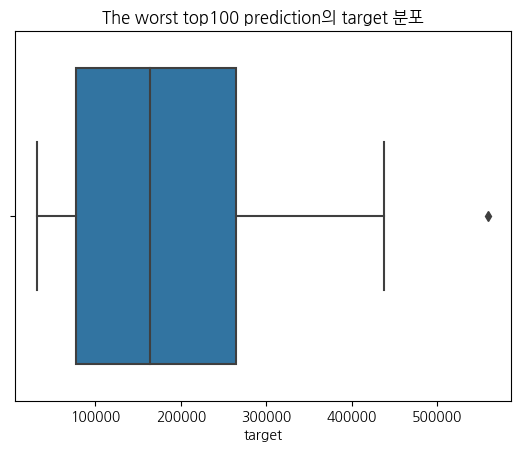

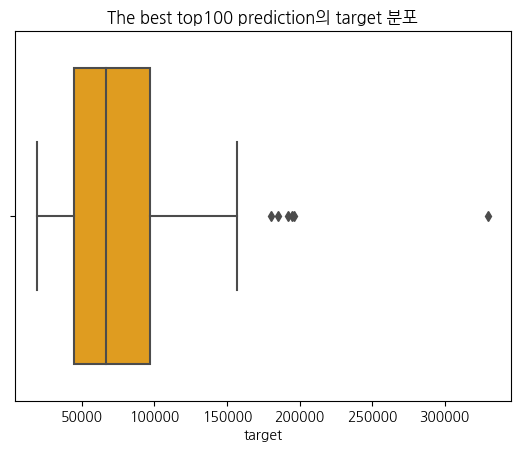

In [ ]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

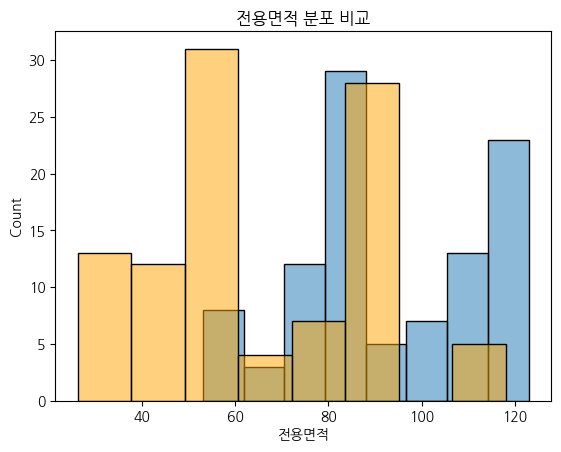

In [ ]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## __✅ 커스텀 모델__

In [ ]:
# Define the original models.
original_models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=100,
        random_state=CONFIG.seed,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=CONFIG.seed
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=-1,
        random_state=CONFIG.seed,
        num_leaves=31,
        verbosity = -1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        random_seed=CONFIG.seed,
        silent=True
    ),
    "HistGradientBoosting": HistGradientBoostingRegressor(
        max_iter=100,
        learning_rate=0.1,
        max_depth=None,
        random_state=CONFIG.seed
    )
}

### __1) Voting 앙상블__ (with Weights)
- 모델별 가중치 추출

In [ ]:
# ### 모델별로 어떤 스케일이 좋은지 판단
def cv_oof_preds(models, X, y, cv):
    """
    Perform cross-validation for each model and generate out-of-fold predictions.

    Args:
    - models: a dictionary of Scikit-learn models
    - X: features
    - y: target variable
    - cv: cross-validation splitter

    Returns:
    - a DataFrame of out-of-fold predictions
    - a list of average CV scores for each model
    """
    # Create a DataFrame to store out-of-fold predictions.
    oof_predictions = pd.DataFrame(index=y.index)

    # Create an empty list to store the average CV scores
    avg_CV_scores = []

    # Iterate over each model and compute cross-validated predictions.
    for name, model in models.items():
        # Create an empty array to store the out-of-fold predictions
        oof_preds = np.zeros(y.shape[0])

        # Create an empty list to store the CV scores
        CV_scores = []

        # Perform cross-validation
        for train_index, valid_index in cv.split(X, y):
            # Clone the model to ensure that it's reset for each fold
            model_clone = clone(model)

            # Split the data
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # Fit the model
            model_clone.fit(X_train, y_train)

            # Compute predictions
            preds = model_clone.predict(X_valid)

            # Store predictions for this fold in oof_preds
            oof_preds[valid_index] = preds

            # Compute the CV score and append it to the list
            score = np.sqrt(metrics.mean_squared_error(y_valid, preds))
            CV_scores.append(score)

        # Store the predictions in the DataFrame
        oof_predictions[name] = oof_preds

        # Store the average CV score and print
        avg_CV_score = np.mean(CV_scores)
        avg_CV_scores.append(avg_CV_score)
        
        print(f"{name} CV Score(Avg): {avg_CV_score:.7f}")
    print(f"★Models CV Score(Avg) = {np.mean(avg_CV_scores):.7f} ± {np.std(avg_CV_scores) * 2:.5f}")

    return oof_predictions


In [ ]:
# LADRegression 모델을 사용하여 각 모델의 예측값에 대한 가중치를 계산하는 방식
def perform_voting(models, X, y, cv):
    oof_predictions = cv_oof_preds(models, X, y, cv)

    # Compute the weights using LAD Regression.
    weights = LADRegression().fit(oof_predictions, y).coef_
    print(pd.DataFrame(weights, index=list(oof_predictions.columns), columns=['weight per model']))

    # Create a voting regressor.
    voting_reg = VotingRegressor(estimators=list(models.items()), weights=weights.tolist())

    # Compute cross-validated Median Absolute Error.
    # Scikit-learn의 교차 검증 함수는 높은 값이 좋은 것으로 간주되므로, 모든 손실 함수에서는 'neg' 접두사가 붙음
    voting_score = -1 * cross_val_score(voting_reg, X, y, scoring='neg_root_mean_squared_error', cv=cv)
    print(f"VotingRegressor CV Score(Avg): {np.mean(voting_score):.7f} ± {np.std(voting_score) * 2:.5f}")

    # Fit the model to the training data.
    voting_reg.fit(X, y)

    return voting_reg

In [ ]:
%%time
'''
Voting 앙상블 예측값 추출
'''
X, y = generateXY(dt_train)
X_test = dt_test.drop(['target'], axis=1)

# 원하는 feature 선택
features = ['아파트명', '도로명']

for i,val in enumerate(X.columns):
    if val not in features:
        X = X.drop(columns=val)

voting_reg = perform_voting(original_models, X, y, CONFIG.kf)

# Voting 앙상블 예측값 추출
test_predictions = voting_reg.predict(X_test)

Random Forest CV Score(Avg): 18194.7237390
XGBoost CV Score(Avg): 41245.9877317


Exception in thread Thread-1656 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\Gyeom\anaconda3\envs\upstage\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Gyeom\anaconda3\envs\upstage\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Gyeom\anaconda3\envs\upstage\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\Gyeom\anaconda3\envs\upstage\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 24: invalid start byte
  File "c:\Users\Gyeom\anaconda3\envs\upstage\lib\site-packages\joblib\externals\loky\backend\context.py", line 262, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 101239, number of used features: 2
[LightGBM] [Info] Start training from score 88495.189107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 101239, number of used features: 2
[LightGBM] [Info] Start training from score 88442.351386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- k-85㎡~135㎡이하
- k-건설사(시공사)
- k-관리방식
- k-관리비부과면적
- k-난방방식
- ...


### __2) Hill_Climbing 앙상블__ (with Weights)

In [ ]:
# def hill_climbing(x, y, x_test):

#     # Evaluating oof predictions
#     scores = {}
#     for col in x.columns:
#         scores[col] = np.sqrt(metrics.mean_squared_error(y, x[col]))

#     # Sorting the model scores
#     scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])} 

#     # Sort oof_df and test_preds
#     x = x[list(scores.keys())]
#     x_test = x_test[list(scores.keys())]

#     STOP = False
#     current_best_ensemble = x.iloc[:,0]
#     current_best_test_preds = x_test.iloc[:,0]
#     MODELS = x.iloc[:,1:]
#     weight_range = np.arange(-0.5, 0.51, 0.01) 
#     history = [np.sqrt(metrics.mean_squared_error(y, current_best_ensemble))]
#     j = 0

#     while not STOP:
#         j += 1
#         potential_new_best_cv_score =np.sqrt(metrics.mean_squared_error(y, current_best_ensemble))
#         k_best, wgt_best = None, None
#         for k in MODELS:
#             for wgt in weight_range:
#                 potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
#                 cv_score = np.sqrt(metrics.mean_squared_error(y, potential_ensemble))
#                 if cv_score < potential_new_best_cv_score: 
#                     potential_new_best_cv_score = cv_score
#                     k_best, wgt_best = k, wgt

#         if k_best is not None:
#             current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
#             current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
#             MODELS.drop(k_best, axis = 1, inplace = True)
#             if MODELS.shape[1] == 0:
#                 STOP = True
#             history.append(potential_new_best_cv_score)
#         else:
#             STOP = True

#     hill_ens_pred_1 = current_best_ensemble
#     hill_ens_pred_2 = current_best_test_preds

#     return [hill_ens_pred_1, hill_ens_pred_2]

In [ ]:
# def perform_hill_climbing(models, X, y, cv):
#     hill_ens_cv_scores, hill_ens_preds = list(), list()

#     for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
#         X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[test_idx]
#         y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[test_idx]

#         preds_train = {}
#         preds_test = {}
#         for name, model in models.items():
#             trained_model = model.fit(X_train_fold, y_train_fold)
#             preds_train[name] = trained_model.predict(X_val_fold)
#             preds_test[name] = trained_model.predict(y_train)

#         oof_df_train, oof_df_test = pd.DataFrame(preds_train), pd.DataFrame(preds_test)

#         hill_results = hill_climbing(oof_df_train, y_val_fold, oof_df_test)

#         hill_ens_score_fold = np.sqrt(metrics.mean_squared_error(y_val_fold, hill_results[0]))
#         hill_ens_cv_scores.append(hill_ens_score_fold)
#         hill_ens_preds.append(hill_results[1])

#         print('Fold', i+1, '==> Hill Climbing Ensemble oof MedAE score is ==>', hill_ens_score_fold)

#     print(f"★The hill climbing ensemble oof MedAE score over the {n_splits}-folds is {np.mean(hill_ens_cv_scores):.7f} ± {np.std(hill_ens_cv_scores) * 2:.5f}")
#     return hill_ens_preds

In [ ]:
# # 힐클라이밍 앙상블 수행

# X, y = X_train, y_train

# # 원하는 feature 선택
# features = ['아파트명', '도로명']

# for i,val in enumerate(X.columns):
#     if val not in features:
#         X = X.drop(columns=val)

# hill_ens_preds = perform_hill_climbing(original_models, X, y, CONFIG.kf)

# # Hill_Climbing 앙상블 예측값 추출
# test_predictions = pd.DataFrame(hill_ens_preds).apply(np.mean, axis = 0)

---

## 6. Inference

In [ ]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,구,동,계약년,계약월,강남여부,신축여부,기준금리(%)
140610,3696,1097,1,259,79.9700,26,5,1987,4665,3,443,396,2,2,1,1,8.0,270.0,235,205,27,22637.0,20204.0,22637.0,20.0,250.0,0.0,199,509,4,1,4,4858.00,262.0,4,699,1,0,127.057210,37.476763,238,0,0,8,2023,7,1,0,3.5
140611,3672,1090,1,260,108.2017,15,10,2021,355,3,438,1239,2,1,1,4,2.0,232.0,282,80,636,44951.0,24878.0,31174.0,0.0,0.0,232.0,201,509,2,2,2,2724.46,305.0,2,695,1,0,127.056394,37.484892,234,0,0,8,2023,8,1,1,3.5


In [ ]:
# # 저장된 모델을 불러옵니다.
# with open('saved_model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [ ]:
# %%time
# X_test = dt_test.drop(['target'], axis=1)

# # Test dataset에 대한 inference를 진행합니다.
# real_test_pred = model.predict(X_test)

CPU times: total: 0 ns
Wall time: 26.4 ms


In [ ]:
# real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([217800., 180300., 250800., ...,  84560.,  74000.,  74400.])

---

## 7. Output File Save

In [ ]:
# # 앞서 예측한 예측값들을 저장합니다.
# preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
# preds_df.to_csv('output.csv', index=False)

In [ ]:
# ✅커스텀 모델 예측값 저장
preds_df = pd.DataFrame(test_predictions.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)